In [1]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import seaborn as sns

### Classe Pipeline

In [2]:
class Pipeline:
    def __init__(self):
        self.tasks = []
        
    def task(self, depends_on=None):
        idx = 0
        if depends_on:
            idx = self.tasks.index(depends_on) + 1
        def inner(f):
            self.tasks.insert(idx, f)
            return f
        return inner
    
    def run(self, input_):
        output = input_
        for task in self.tasks:
            output = task(output)
        return output

Instanciando um objeto da classe pipeline

In [3]:
pipeline = Pipeline()

Define o primeiro nó do pipeline, a função responsável por gerar o grafo a partir de uma página wikipedia. 

In [4]:
@pipeline.task()
def fetch_wikipedia_graph(seed, num_layers=2, debug=True):
    """
    Fetches Wikipedia page data and captures the nodes and edges up to a specified number of layers.

    Args:
        seed (str): The seed page title to start the traversal.
        num_layers (int, optional): The number of layers to traverse from the seed page. Defaults to 2.
        debug (bool, optional): Flag to enable debug mode for displaying progress information. Defaults to False.

    Returns:
        networkx.DiGraph: A directed graph representing the nodes and edges captured from Wikipedia.

    Raises:
        WikipediaException: If there's an error loading a page.

    """
    print('Capturing data')
    seed = seed.title()
    stops = (
        "International Standard Serial Number",
        "International Standard Book Number",
        "National Diet Library",
        "International Standard Name Identifier",
        "International Standard Book Number (Identifier)",
        "Pubmed Identifier",
        "Pubmed Central",
        "Digital Object Identifier",
        "Arxiv",
        "Proc Natl Acad Sci Usa",
        "Bibcode",
        "Library Of Congress Control Number",
        "Jstor",
        "Doi (Identifier)",
        "Isbn (Identifier)",
        "Pmid (Identifier)",
        "Arxiv (Identifier)",
        "Bibcode (Identifier)"
    )
    todo_lst = [(0, seed)]
    todo_set = set(seed)
    done_set = set()
    graph = nx.DiGraph()

    while todo_lst and todo_lst[0][0] < num_layers:
        layer, page = todo_lst.pop(0)
        done_set.add(page)

        # Show progress
        if debug:
            print(layer, page)

        try:
            wiki = wikipedia.page(page)
        except:
            if debug:
                print("Could not load", page)
            continue

        for link in wiki.links:
            link = link.title()
            if link not in stops and not link.startswith("List Of"):
                if link not in todo_set and link not in done_set:
                    todo_lst.append((layer + 1, link))
                    todo_set.add(link)
                graph.add_edge(page, link)

    print('Data capture finished')
    print("{} nodes, {} edges".format(len(graph), nx.number_of_edges(graph)))

    return graph


Define o próximo nó do pipeline, a função responsável por remover os nós duplicados

In [5]:
@pipeline.task(depends_on=fetch_wikipedia_graph)
def remove_duplicate_nodes(graph):
    """
    Removes duplicate nodes and edges from the graph.

    Args:
        graph (networkx.DiGraph): The graph representing Wikipedia nodes and edges.

    Returns:
        networkx.DiGraph: The graph with duplicate nodes and edges removed.

    """

    graph.remove_edges_from(nx.selfloop_edges(graph))

    duplicates = [(node, node + "s")
                  for node in graph if node + "s" in graph
                 ]

    for dup in duplicates:
        graph = nx.contracted_nodes(graph, *dup, self_loops=False)

    print(duplicates)

    duplicates = [(x, y) for x, y in
                  [(node, node.replace("-", " ")) for node in graph]
                  if x != y and y in graph]
    print(duplicates)

    for dup in duplicates:
        graph = nx.contracted_nodes(graph, *dup, self_loops=False)

    nx.set_node_attributes(graph, 0, "contraction")
    nx.set_edge_attributes(graph, 0, "contraction")
    print('Duplicates removed')
    print("{} nodes, {} edges".format(len(graph), nx.number_of_edges(graph)))

    return graph


Define o próximo nó do pipeline, a função responsável por remover os nós duplicados

In [6]:
@pipeline.task(depends_on=remove_duplicate_nodes)
def filter_high_degree_nodes(graph, degree=2):
    """
    Filters nodes in the graph based on their degree.

    Args:
        graph (networkx.DiGraph): The graph representing Wikipedia nodes and edges.
        degree (int, optional): The minimum degree threshold for filtering nodes. Defaults to 2.

    Returns:
        networkx.DiGraph: The subgraph containing nodes with degree greater than the specified threshold.

    """

    core = [node for node, drg in dict(graph.degree()).items() if drg > degree]
    subgraph = graph.subgraph(core)
    print('Filter')
    print("{} nodes, {} edges".format(len(subgraph), nx.number_of_edges(subgraph)))
    nx.write_graphml(subgraph, "cna.graphml")
    
    return subgraph


Nó do pipeline responsável pelo plot dos resultados

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from plot_metrics import (
    plot_centrality,
    plot_degree_centrality,
    plot_closeness_centrality,
    plot_betweenness_centrality,
    plot_eigenvector_centrality,
    plot_degree_and_centrality,
)

@pipeline.task(depends_on=filter_high_degree_nodes)
def plot_results(subgraph):
    """
    Shows the results of the analysis by plotting various centrality measures and creating visualizations.

    Args:
        subgraph (networkx.DiGraph): The subgraph containing filtered nodes based on degree.

    """

    pos = nx.spring_layout(subgraph, seed=8375, k=0.2)

    plot_degree_centrality(subgraph)
    plot_closeness_centrality(subgraph)
    plot_betweenness_centrality(subgraph)
    plot_eigenvector_centrality(subgraph)

    bc = pd.Series(nx.betweenness_centrality(subgraph))
    dc = pd.Series(nx.degree_centrality(subgraph))
    ec = pd.Series(nx.eigenvector_centrality(subgraph))
    cc = pd.Series(nx.closeness_centrality(subgraph))

    df = pd.DataFrame.from_dict({"Betweenness": bc,
                                 "Degree": dc,
                                 "EigenVector": ec,
                                 "Closeness": cc})
    print('Plot all')
    df.reset_index(inplace=True, drop=True)
    fig = sns.PairGrid(df)
    fig.map_upper(sns.scatterplot)
    fig.map_lower(sns.kdeplot, cmap="Reds_r")
    fig.map_diag(sns.kdeplot, lw=2, legend=False)

    plt.savefig('all.png', transparent=True, dpi=800, bbox_inches="tight")
    plt.show()
    print('Plot Core and shell')
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    g2_core_9 = nx.k_shell(subgraph, 243)
    g2_core_10 = nx.k_core(subgraph, 394)

    pos = nx.spring_layout(subgraph, seed=123456789, k=0.3)

    nx.draw_networkx_edges(subgraph, pos=pos, alpha=0.4, ax=ax)

    nodes = nx.draw_networkx_nodes(subgraph, pos=pos, node_color="#333333")
    nodes = nx.draw_networkx_nodes(g2_core_9, pos=pos, node_color="blue")
    nodes = nx.draw_networkx_nodes(g2_core_10, pos=pos, node_color="red")

    red_patch = mpatches.Patch(color='red', label='394-core')
    blue_patch = mpatches.Patch(color='blue', label='243-shell')
    plt.legend(handles=[red_patch, blue_patch])

    plt.axis("off")
    plt.savefig('k-core_sociopatterns.png', transparent=True, dpi=600)
    plt.show()


Capturing data
0 Gödel'S Incompleteness Theorems
1 A. K. Peters
1 Ascii


/home/andremeneses/Documents/envs/data/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/andremeneses/Documents/envs/data/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Could not load Ascii
1 Abstract Logic
1 Ackermann Set Theory
1 Alan Sokal
1 Alan Turing
Could not load Alan Turing
1 Aleph Number
1 Alfred Tarski
1 Algebraically Closed Field
1 Algorithm
1 Algorithmic Information Theory
1 Alonzo Church
Could not load Alonzo Church
1 Alphabet (Formal Languages)
1 Anti-Realist
1 Argument
1 Arithmetical Hierarchy
1 Arity
Could not load Arity
1 Atomic Formula
1 Atomic Sentence
1 Automata Theory
1 Automated Theorem Proving
1 Avi Wigderson
1 Axiom
1 Axiom Of Choice
Could not load Axiom Of Choice
1 Axiom Schema
1 Axiom Schema Of Specification
1 Axiomatic System
1 Axiomatization Of Boolean Algebras
1 Bbc
Could not load Bbc
1 Banach–Tarski Paradox
1 Berry'S Paradox
1 Bertrand Russell
1 Bew
1 Bew (Disambiguation)
Could not load Bew (Disambiguation)
1 Bijection
Could not load Bijection
1 Binary Operation
1 Bob Hale (Philosopher)
1 Bona Fide
1 Boolean Algebra
1 Boolean Algebras Canonically Defined
1 Boolean Function
1 Cantor'S Diagonal Argument
1 Cantor'S Paradox


1 Richard Zach
1 Robinson Arithmetic
1 Roger Penrose
Could not load Roger Penrose
1 Rosser'S Trick
1 Rudy Rucker
1 Rule Of Inference
1 Russell'S Paradox
1 Régis Debray
1 S2Cid (Identifier)
1 Saharon Shelah
1 Satisfiability
Could not load Satisfiability
1 Saturated Model
1 Saul Kripke
1 Schröder–Bernstein Theorem
1 Second-Order Arithmetic
1 Second-Order Logic
1 Second Conference On The Epistemology Of The Exact Sciences
1 Self-Verifying Theories
1 Self Reference
1 Semantic Theory Of Truth
1 Semantics Of Logic
1 Sentence (Mathematical Logic)
1 Sequent Calculus
Could not load Sequent Calculus
1 Set (Mathematics)
1 Set Theory
1 Sidney Hook
1 Signature (Logic)
1 Singleton (Mathematics)
1 Skolem Arithmetic
1 Solomon Feferman
1 Soundness
1 Spectrum Of A Sentence
1 Spectrum Of A Theory
1 Square Of Opposition
1 Stanford Encyclopedia Of Philosophy
1 Stanley Jaki
1 Stephen Cole Kleene
1 Stephen Hawking
1 Stewart Shapiro
1 Strength (Mathematical Logic)
1 String (Formal Languages)
1 Structure (Math

Duplicates removed
24114 nodes, 119066 edges
Filter
5446 nodes, 97540 edges


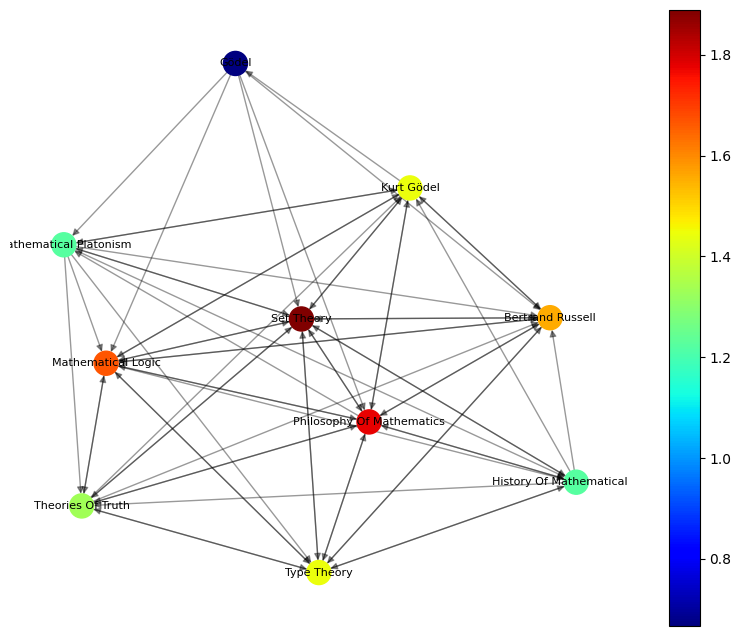

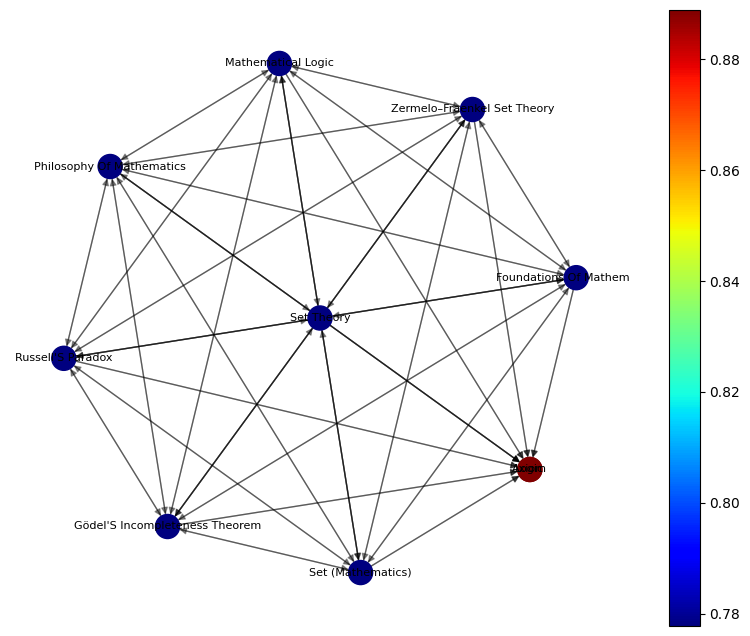

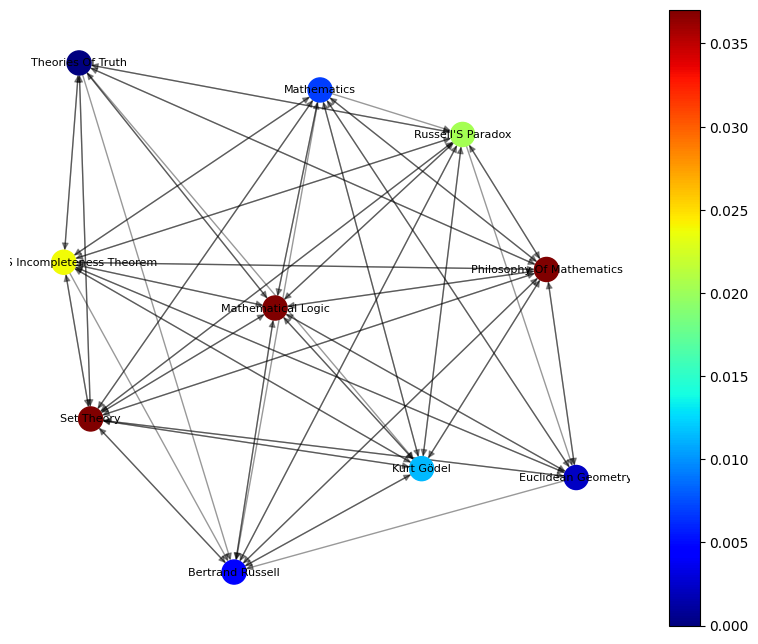

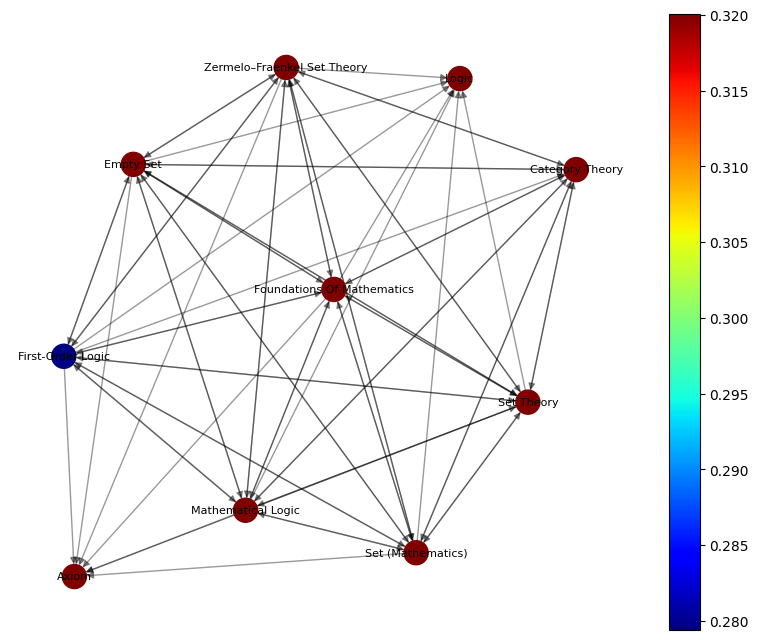

Plot all


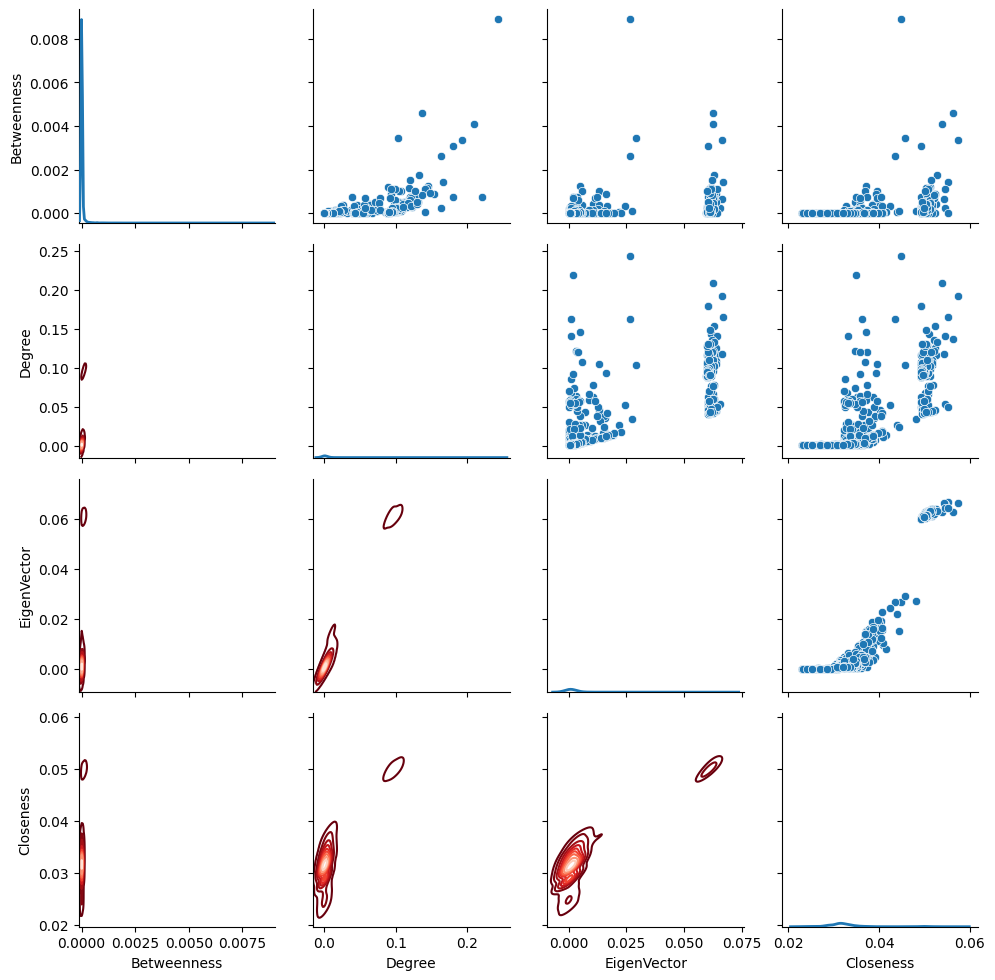

Plot Core and shell


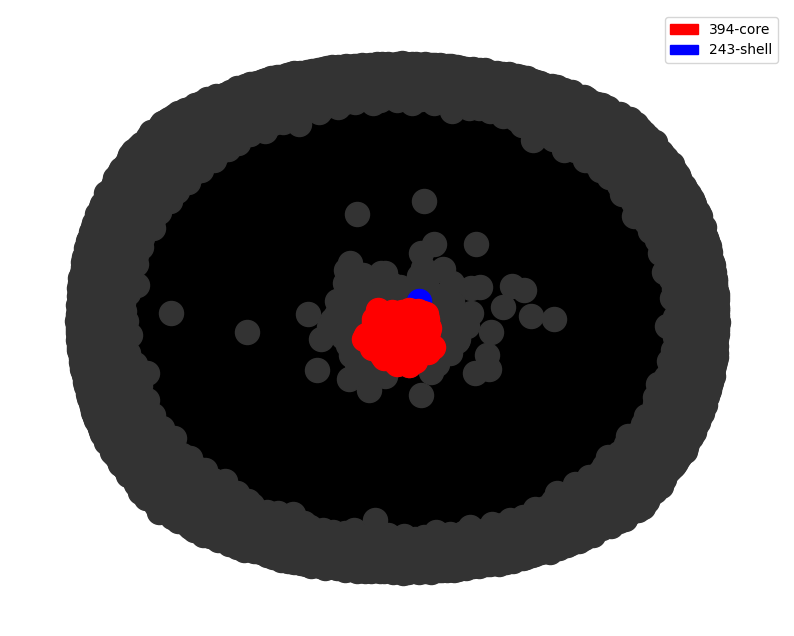

In [8]:
pipeline.run("Gödel's incompleteness theorems")